Instalacja i importowanie niezbędnych bibliotek itp

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

     |████████████████████████████████| 5.4 MB 7.3 MB/s 
     |████████████████████████████████| 155 kB 77.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.4 which is incompatible.


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [6]:
X /= 255.0

In [7]:
X.min(), X.max()

(0.0, 1.0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [10]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

Wyświetlenie wybranych obrazów treningowych

In [11]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

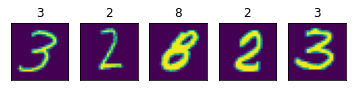

In [12]:
plot_example(X_train, y_train)

budwa sieci neuronowej na za pomocą pyTorch

In [13]:
import torch
from torch import nn
import torch.nn.functional as F

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [16]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [17]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

importowanie modułu z skorch

In [18]:
from skorch import NeuralNetClassifier

In [19]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [20]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8352       0.8786        0.4214  1.2505
      2        0.4340       0.9115        0.3170  0.9120
      3        0.3625       0.9208        0.2769  0.8846
      4        0.3235       0.9287        0.2388  0.8905
      5        0.2925       0.9343        0.2181  0.9001
      6        0.2722       0.9421        0.1959  0.8871
      7        0.2546       0.9441        0.1888  0.8954
      8        0.2439       0.9473        0.1766  0.8857
      9        0.2303       0.9515        0.1646  0.9134
     10        0.2237       0.9545        0.1562  0.8900
     11        0.2162       0.9545        0.1510  0.8917
     12        0.2070       0.9550        0.1481  0.9086
     13        0.2020       0.9576        0.1422  0.8847
     14        0.1960       0.9574        0.1410  0.9174
     15        0.1898       0.9582        0.1375  0.9205
     16        0.1854       0.9

In [21]:
from sklearn.metrics import accuracy_score

ustawienie danych i wywołanie sieci do rozpoznania wybranych obrazów oraz pokazanie % skuteczności w rozpoznawaniu

In [26]:
XCnn = X.reshape(-1, 1, 28, 28)

In [27]:
XCnn.shape

(70000, 1, 28, 28)

In [28]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [29]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [30]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [31]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [32]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4152       0.9729        0.0880  2.0790
      2        0.1562       0.9804        0.0630  1.7828
      3        0.1276       0.9832        0.0543  1.7602
      4        0.1148       0.9837        0.0501  1.7709
      5        0.0978       0.9858        0.0476  1.7599
      6        0.0893       0.9868        0.0460  1.7601
      7        0.0840       0.9875        0.0417  1.7753
      8        0.0835       0.9885        0.0381  1.7856
      9        0.0765       0.9892        0.0368  1.7622
     10        0.0748       0.9871        0.0415  1.7708


In [33]:
y_pred_cnn = cnn.predict(XCnn_test)

In [34]:
accuracy_score(y_test, y_pred_cnn)

0.9874285714285714

In [35]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7556904400606981

wyświetlenie wyników

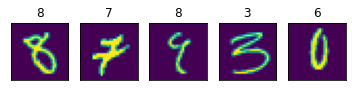

In [36]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])